# Assignment 4: Hamiltonian Learning of Spin-1/2 Chains
Now we will implement a more complex hamiltonian to see if vanilla and Neural ODE-based optimization can learn the parameters. 


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import functools
import scipy.linalg
torch.set_default_dtype(torch.float64)

## Definitions

In [2]:
def kron(args):
    """Kronecker product for variable-length arguments."""
    backend = np if isinstance(args[0], np.ndarray) else __import__("torch")
    return functools.reduce(backend.kron, args)

def paulis():
    """Returns Pauli matrices I, X, Y, Z."""
    I = np.eye(2, dtype=np.complex128)
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)
    return I, X, Y, Z


def single_qubit_measurement_unitary(axis: int) -> np.ndarray:
    """
    Rotation unitary for measurement basis.
    axis: 0->X, 1->Y, 2->Z
    Applies H for X, S†H for Y, identity for Z.
    """
    H = np.array([[1, 1], [1, -1]], dtype=np.complex128) / np.sqrt(2)
    Sdg = np.array([[1, 0], [0, -1j]], dtype=np.complex128)

    if axis == 0:      # X
        return H
    elif axis == 1:    # Y
        return Sdg @ H
    elif axis == 2:    # Z
        return np.eye(2, dtype=np.complex128)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def rotate_state_for_pauli_measurement(state: np.ndarray, pauli_obs: np.ndarray) -> np.ndarray:
    """
    Apply U = U_i(pauli_obs[i]) to convert measurement in {X,Y,Z}^n
    to computational basis measurement.
    """
    U_factors = [single_qubit_measurement_unitary(int(a)) for a in pauli_obs]
    U = kron(U_factors)
    return U @ state


## Hamiltonian

In [3]:
# 1) Hamiltonian (Transverse Ising)
#    H = a * sum_i X_i X_{i+1} + b * sum_i Z_i
def build_richer_hamiltonian_dense(n: int, params: dict) -> np.ndarray:
    """
    More complex Hamiltonian (option 1: more terms):
      H = sum_i [Jxx X_iX_{i+1} + Jyy Y_iY_{i+1} + Jzz Z_iZ_{i+1}]
        + sum_i [hx X_i + hz Z_i]

    params must contain: {"Jxx","Jyy","Jzz","hx","hz"}
    """
    I, X, Y, Z = paulis()
    dim = 2**n
    H = np.zeros((dim, dim), dtype=np.complex128)

    Jxx = params["Jxx"]
    Jyy = params["Jyy"]
    Jzz = params["Jzz"]
    hx  = params["hx"]
    hz  = params["hz"]

    # Neighbor interactions
    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X; ops[i + 1] = X
        H += Jxx * kron(ops)

        ops = [I] * n
        ops[i] = Y; ops[i + 1] = Y
        H += Jyy * kron(ops)

        ops = [I] * n
        ops[i] = Z; ops[i + 1] = Z
        H += Jzz * kron(ops)

    # Local fields
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H += hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H += hz * kron(ops)

    # Defensive Hermiticity
    H = 0.5 * (H + H.conj().T)
    return H


# 2) Generate dataset like Algorithm 9
def basis_state(n: int, index: int) -> np.ndarray:
    """State |index> in computational basis, as vector (2^n,)."""
    v = np.zeros(2**n, dtype=np.complex128)
    v[index] = 1.0
    return v


def plus_state(n: int) -> np.ndarray:
    """State |+>^{xn}"""
    v_plus = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2)
    return kron([v_plus] * n)


def random_product_state(n: int, rng: np.random.Generator) -> np.ndarray:
    """
    Random product state: x_i (cos(theta/2)|0> + e^{i phi} sin(theta/2)|1>)
    """
    vecs = []
    for _ in range(n):
        theta = rng.uniform(0.0, np.pi)
        phi = rng.uniform(0.0, 2 * np.pi)
        v = np.array([np.cos(theta / 2), np.exp(1j * phi) * np.sin(theta / 2)], dtype=np.complex128)
        v = v / np.linalg.norm(v)
        vecs.append(v)
    return kron(vecs)


def evolve_state_exact(H: np.ndarray, psi0: np.ndarray, t: float) -> np.ndarray:
    """
    Exact evolution: psi(t) = exp(-i H t) psi0
    """
    U = scipy.linalg.expm(-1j * t * H)
    psi_t = U @ psi0
    # Defensive normalization
    psi_t = psi_t / np.linalg.norm(psi_t)
    return psi_t


def sample_measurements_in_pauli_basis(
    psi_t: np.ndarray,
    pauli_obs: np.ndarray,
    shots: int,
    rng: np.random.Generator
) -> np.ndarray:
    """
    Simulate measurements: rotate state to measure in given Pauli basis
    then sample computational basis indices according to |amp|^2.

    Returns: array shape (shots,) with integers in [0, 2^n - 1]
    """
    psi_rot = rotate_state_for_pauli_measurement(psi_t, pauli_obs)
    probs = np.abs(psi_rot) ** 2
    probs = probs / probs.sum()
    samples = rng.choice(np.arange(probs.shape[0]), size=shots, p=probs).astype(np.int64)
    return samples


def generate_dataset_algorithm9_style(
    n: int,
    true_params: dict,
    num_initial_states: int = 3,
    num_times: int = 20,
    dt: float = 0.2,
    num_paulis: int = 30,
    shots: int = 200,
    seed: int = 0,
):
    """
    Generate dataset like Algorithm 9:
      - initial_states: list of initial states (vectors)
      - times: array (num_times,)
      - pauli_obs: array (num_paulis, n) with entries 0/1/2 (X/Y/Z)
      - samples: array (S, T, P, shots) with indices in computational basis

    true_params: dict with keys needed to build H.
    """
    rng = np.random.default_rng(seed)

    # True Hamiltonian
    true_params = {"Jxx": 1.0, "Jyy": 0.7, "Jzz": 0.4, "hx": 0.3, "hz": 0.9}
    H_true = build_richer_hamiltonian_dense(n=n, params=true_params)

    # Initial states
    initial_states = []
    if num_initial_states >= 1:
        initial_states.append(basis_state(n, 0))
    if num_initial_states >= 2:
        initial_states.append(plus_state(n))
    while len(initial_states) < num_initial_states:
        initial_states.append(random_product_state(n, rng))

    initial_states = np.stack(initial_states, axis=0)

    # Times
    times = dt * (np.arange(1, num_times + 1))

    # Random local Pauli observables: 0(X), 1(Y), 2(Z)
    pauli_obs = rng.integers(0, 3, size=(num_paulis, n), endpoint=False)

    # Sampling
    S = initial_states.shape[0]
    samples = np.empty((S, num_times, num_paulis, shots), dtype=np.int64)

    for s in range(S):
        psi0 = initial_states[s]
        for ti, t in enumerate(times):
            psi_t = evolve_state_exact(H_true, psi0, float(t))
            for p in range(num_paulis):
                samples[s, ti, p, :] = sample_measurements_in_pauli_basis(
                    psi_t=psi_t,
                    pauli_obs=pauli_obs[p],
                    shots=shots,
                    rng=rng
                )

    dataset = {
        "n": n,
        "true_params": true_params,
        "initial_states": initial_states,
        "times": times,
        "pauli_obs": pauli_obs,
        "samples": samples,
    }
    return dataset


def save_dataset_npz(dataset: dict, filename: str = "dataset_part2_algorithm9.npz"):
    """Save dataset to NPZ file."""
    np.savez_compressed(
        filename,
        n=dataset["n"],
        true_params=str(dataset["true_params"]),
        initial_states=dataset["initial_states"],
        times=dataset["times"],
        pauli_obs=dataset["pauli_obs"],
        samples=dataset["samples"],
    )



## Dataset

In [4]:
n = 8  # number of qubits

true_params = {"Jxx": 1.0, "Jyy": 0.7, "Jzz": 0.4, "hx": 0.3, "hz": 0.9}

dataset = generate_dataset_algorithm9_style(
    n=n,
    true_params=true_params,
    num_initial_states=3,
    num_times=30,   
    dt=0.2,
    num_paulis=80, 
    shots=200,    
    seed=42,
)

print("initial_states:", dataset["initial_states"].shape)  # (S, 2^n)
print("times:", dataset["times"].shape)                    # (T,)
print("pauli_obs:", dataset["pauli_obs"].shape)            # (P, n)
print("samples:", dataset["samples"].shape)                # (S, T, P, shots)

save_dataset_npz(dataset, "dataset_part2_algorithm9_richer.npz")
print("Saved -> dataset_part2_algorithm9_richer.npz")

# Print dataset
print("\n=== DATASET HEAD ===")
print("\nInitial state [0] (first 5 amplitudes):")
print(dataset["initial_states"][0][:5])

print("\nTimes (first 5):")
print(dataset["times"][:5])

print("\nPauli observable [0] (0=X, 1=Y, 2=Z):")
print(dataset["pauli_obs"][0])

print("\nSamples [state=0, time=0, pauli=0] (first 10 shots):")
print(dataset["samples"][0, 0, 0, :10])
# Each number is a measurement outcome, i.e., a measured bitstring.
# Example: 5 -> '00000101' in binary, meaning |0> was measured on qubits 0,2 and |1> on qubits 1,3,...


initial_states: (3, 256)
times: (30,)
pauli_obs: (80, 8)
samples: (3, 30, 80, 200)
Saved -> dataset_part2_algorithm9_richer.npz

=== DATASET HEAD ===

Initial state [0] (first 5 amplitudes):
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Times (first 5):
[0.2 0.4 0.6 0.8 1. ]

Pauli observable [0] (0=X, 1=Y, 2=Z):
[0 1 2 0 2 2 0 1]

Samples [state=0, time=0, pauli=0] (first 10 shots):
[  3 147   2 209  16 210 193 131 193 193]


## Hamiltonian Ansatz

In [5]:

# 4) Ansatz Hamiltonian: Ising Model
# H_A(params) = Jxx * sum_i X_i X_{i+1}
#             + Jyy * sum_i Y_i Y_{i+1}
#             + Jzz * sum_i Z_i Z_{i+1}
#             + hx  * sum_i X_i
#             + hz  * sum_i Z_i

def kron(args):
    """Kronecker product with variable-length arguments."""
    backend = np if isinstance(args[0], np.ndarray) else torch
    return functools.reduce(backend.kron, args)


def paulis_torch(device="cpu"):
    """Return Pauli matrices as torch tensors."""
    I = torch.eye(2, dtype=torch.complex128, device=device)
    X = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128, device=device)
    Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128, device=device)
    Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128, device=device)
    return I, X, Y, Z


def single_qubit_measurement_unitary_torch(axis: int, device="cpu") -> torch.Tensor:
    """Rotation unitary to measure in X/Y/Z basis via computational basis."""
    H = torch.tensor([[1, 1], [1, -1]], dtype=torch.complex128, device=device) / np.sqrt(2)
    Sdg = torch.tensor([[1, 0], [0, -1j]], dtype=torch.complex128, device=device)

    if axis == 0:  # X
        return H
    elif axis == 1:  # Y
        return Sdg @ H
    elif axis == 2:  # Z
        return torch.eye(2, dtype=torch.complex128, device=device)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def build_rotation_operator(pauli_obs_row: np.ndarray, device="cpu") -> torch.Tensor:
    """Build rotation operator U = x_i U_i(basis[i])."""
    factors = [single_qubit_measurement_unitary_torch(int(a), device=device) for a in pauli_obs_row]
    return kron(factors)


def build_ansatz_hamiltonian_torch(n: int, params: torch.Tensor, device="cpu") -> torch.Tensor:
    """
    Build ansatz Hamiltonian with 5 parameters.
    
    params: tensor shape (5,) = [Jxx, Jyy, Jzz, hx, hz]
    """
    Jxx, Jyy, Jzz, hx, hz = params[0], params[1], params[2], params[3], params[4]

    I, X, Y, Z = paulis_torch(device=device)
    dim = 2**n
    H = torch.zeros((dim, dim), dtype=torch.complex128, device=device)

    # Nearest-neighbour interactions
    for i in range(n - 1):
        ops = [I] * n
        ops[i], ops[i + 1] = X, X
        H = H + Jxx * kron(ops)

        ops = [I] * n
        ops[i], ops[i + 1] = Y, Y
        H = H + Jyy * kron(ops)

        ops = [I] * n
        ops[i], ops[i + 1] = Z, Z
        H = H + Jzz * kron(ops)

    # Local fields
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H = H + hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H = H + hz * kron(ops)

    H = 0.5 * (H + H.conj().T)
    return H


def evolve_state_matrix_exp(H: torch.Tensor, psi0: torch.Tensor, t: float) -> torch.Tensor:
    """Evolve state via matrix exponential: psi(t) = exp(-i H t) psi0."""
    U = torch.matrix_exp((-1j * t) * H)
    psi_t = U @ psi0
    psi_t = psi_t / torch.linalg.norm(psi_t)
    return psi_t


def probs_in_measurement_basis(psi_t: torch.Tensor, Urot: torch.Tensor) -> torch.Tensor:
    """Compute measurement probabilities after rotating to measurement basis."""
    psi_rot = Urot @ psi_t
    probs = torch.abs(psi_rot) ** 2
    return probs / torch.sum(probs)


## Vanilla

Step    1/100 | NLL=5.870505 | Jxx=0.9153 (true 1.0000) | Jyy=1.0200 (true 0.7000) | Jzz=0.5088 (true 0.4000) | hx=0.4769 (true 0.3000) | hz=0.2821 (true 0.9000)
Step    2/100 | NLL=5.702946 | Jxx=0.8758 (true 1.0000) | Jyy=1.0231 (true 0.7000) | Jzz=0.5536 (true 0.4000) | hx=0.4529 (true 0.3000) | hz=0.3320 (true 0.9000)
Step    3/100 | NLL=5.604806 | Jxx=0.8402 (true 1.0000) | Jyy=1.0155 (true 0.7000) | Jzz=0.5975 (true 0.4000) | hx=0.4336 (true 0.3000) | hz=0.3818 (true 0.9000)
Step    4/100 | NLL=5.473712 | Jxx=0.7994 (true 1.0000) | Jyy=0.9900 (true 0.7000) | Jzz=0.6372 (true 0.4000) | hx=0.4047 (true 0.3000) | hz=0.4313 (true 0.9000)
Step    5/100 | NLL=5.341452 | Jxx=0.7599 (true 1.0000) | Jyy=0.9564 (true 0.7000) | Jzz=0.6795 (true 0.4000) | hx=0.3705 (true 0.3000) | hz=0.4793 (true 0.9000)
Step    6/100 | NLL=5.355050 | Jxx=0.7389 (true 1.0000) | Jyy=0.9396 (true 0.7000) | Jzz=0.6879 (true 0.4000) | hx=0.3516 (true 0.3000) | hz=0.5233 (true 0.9000)
Step    7/100 | NLL=5.359295

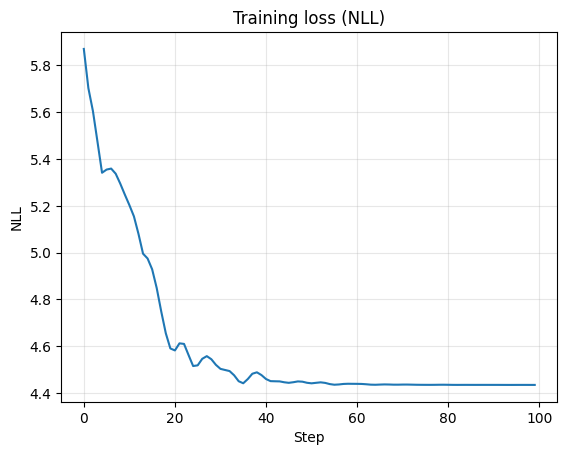

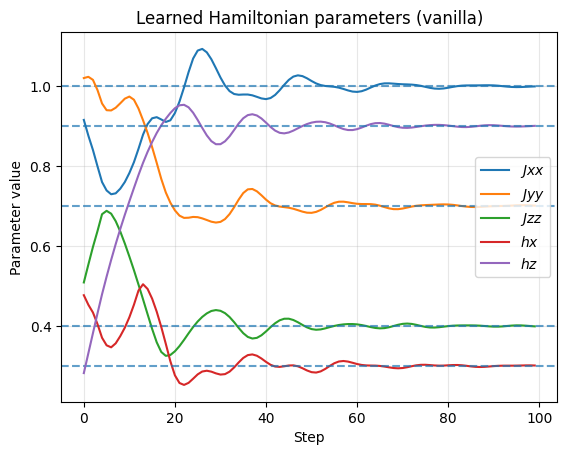

In [ ]:

# 5) Training (NLL) — VANILLA 
def train_vanilla_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    init_params=None,
    patience_stop: int = 30,   
    min_delta: float = 1e-5,  
):
    """
    Minimizes NLL over samples:
      NLL = - mean_{s,t,p,shot} log p_theta( sample )

    Generalized version for a Hamiltonian with 5 parameters:
      params = [Jxx, Jyy, Jzz, hx, hz]

    Early stopping:
      If the NLL does not improve by at least `min_delta` during `patience_stop` iterations,
      training stops before reaching `num_steps`.
    """
    n = int(dataset["n"])
    times = dataset["times"]                 # (T,) numpy
    pauli_obs = dataset["pauli_obs"]         # (P,n) numpy
    samples = dataset["samples"]             # (S,T,P,shots) numpy
    init_states = dataset["initial_states"]  # (S,2^n) numpy complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # Convert initial states to torch
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # Precompute rotation matrices for each pauli observable 
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  

    if init_params is None:
        init_params = [0.5, 0.5, 0.5, 0.5, 0.5]

    params = torch.nn.Parameter(torch.tensor(init_params, dtype=torch.float64, device=device))
    opt = torch.optim.Adam([params], lr=lr)

    loss_hist = []
    param_hist = []

    # True parameters for plotting (from dataset)
    true_dict = dataset["true_params"]
    param_names = ["Jxx", "Jyy", "Jzz", "hx", "hz"]
    true_vec = np.array([float(true_dict[k]) for k in param_names], dtype=np.float64)

    # Early stopping state
    best_nll = float("inf")
    steps_since_improve = 0

    # Training loop
    for step in range(num_steps):
        opt.zero_grad()

        # Build H(params)
        H = build_ansatz_hamiltonian_torch(n, params.to(torch.complex128), device=device)

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device)
        count = 0

        for s in range(S):
            psi0 = init_states_t[s] 
            for ti in range(T):
                t = float(times[ti])
                psi_t = evolve_state_matrix_exp(H, psi0, t)

                for p in range(P):
                    probs = probs_in_measurement_basis(psi_t, Urots[p])
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device)  
                    p_samp = probs[idx]  
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps))
                    count += shots

        nll = -total_logp / count
        nll.backward()
        opt.step()

        nll_val = float(nll.detach().cpu().item())
        loss_hist.append(nll_val)
        param_hist.append(params.detach().cpu().numpy().copy())

        # Compact print
        cur = param_hist[-1]
        print(
            f"Step {step+1:4d}/{num_steps} | NLL={nll_val:.6f} | "
            f"Jxx={cur[0]:.4f} (true {true_vec[0]:.4f}) | "
            f"Jyy={cur[1]:.4f} (true {true_vec[1]:.4f}) | "
            f"Jzz={cur[2]:.4f} (true {true_vec[2]:.4f}) | "
            f"hx={cur[3]:.4f} (true {true_vec[3]:.4f}) | "
            f"hz={cur[4]:.4f} (true {true_vec[4]:.4f})"
        )

        # Early stopping check
        if nll_val < best_nll - min_delta:
            best_nll = nll_val
            steps_since_improve = 0
        else:
            steps_since_improve += 1

        if steps_since_improve >= patience_stop:
            print(
                f"[EarlyStopping] Stopping at step {step+1} because NLL does not improve "
                f"(min_delta={min_delta}) in {patience_stop} iterations. Best NLL={best_nll:.6f}"
            )
            break

    history = {
        "loss": np.array(loss_hist),
        "params": np.array(param_hist),   # (num_steps, 5)
        "true": true_vec,                 # (5,)
        "names": param_names,
    }
    return history
init_params = np.random.uniform(0.1, 1, size=5)
history = train_vanilla_model(dataset, num_steps=100, lr=0.05, device="cpu", init_params=init_params)

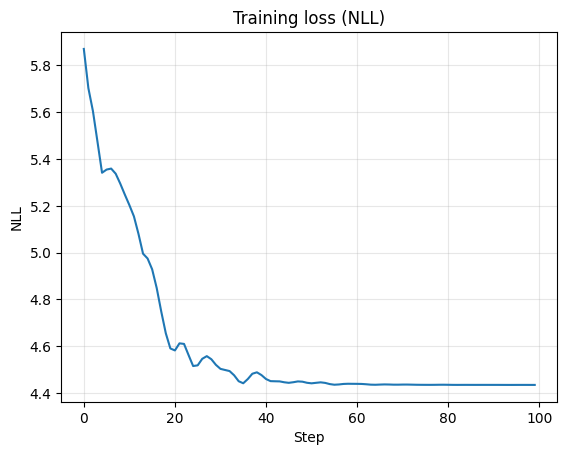

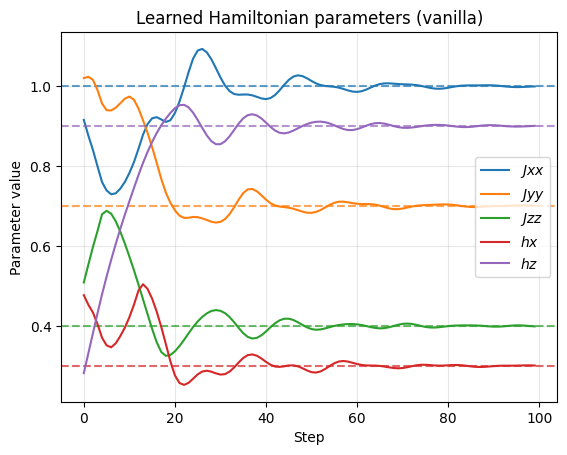

In [9]:


def plot_training(history: dict):
    loss = history["loss"]
    params = history["params"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(params.shape[1])])

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (NLL)")
    plt.grid(alpha=0.3)
    plt.show()

    # Parameters
    plt.figure()
    steps = np.arange(len(params))
    for k in range(params.shape[1]):
        plt.plot(steps, params[:, k], label=rf"${names[k]}$")
        plt.axhline(true_vec[k], linestyle="--",color=plt.gca().lines[-1].get_color(), alpha=0.7)

    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (vanilla)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


plot_training(history)


## Neural ODE

In [11]:
# Neural ODE: RK4 integrator for Schrödinger equation
# dpsi/dt = -i H psi

def rk4_step(psi, dt, H):
    # RK4 step WITHOUT renormalizing inside the integrator
    k1 = (-1j) * (H @ psi)
    k2 = (-1j) * (H @ (psi + 0.5 * dt * k1))
    k3 = (-1j) * (H @ (psi + 0.5 * dt * k2))
    k4 = (-1j) * (H @ (psi + dt * k3))
    psi_next = psi + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return psi_next


def integrate_ode_rk4(psi0, times_torch, H, m=20):
    """
    Integrate from t=0 to each time in times_torch using RK4 with m substeps.
    Normalization is applied only when storing psi(t_k), not inside RK4.
    """
    states = []
    t_prev = 0.0
    psi = psi0

    for t in times_torch:
        t_target = float(t.item())
        dt_big = t_target - t_prev
        dt = dt_big / m

        for _ in range(m):
            psi = rk4_step(psi, dt, H)
            t_prev += dt
        psi = psi / torch.linalg.norm(psi)
        states.append(psi)

    return torch.stack(states, dim=0) 


# Neural map NN_phi
class CoeffNet(nn.Module):
    def __init__(self, hidden=32, dim_params=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_params, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim_params),
        )

    def forward(self, c):
        return self.net(c)


def plot_training_nde_eff(history: dict):
    loss = history["loss"]
    c_eff = history["c_eff"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(c_eff.shape[1])])
    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (Neural ODE)")
    plt.grid(alpha=0.3)
    plt.show()
    plt.figure()
    steps = np.arange(len(c_eff))
    for k in range(c_eff.shape[1]):
        plt.plot(steps, c_eff[:, k], label=rf"${names[k]}^{{eff}}$")
        plt.axhline(true_vec[k], linestyle="--", color=plt.gca().lines[-1].get_color(),alpha=0.7)

    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (effective)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## Training ODE

[NDE] Step    1/500 | NLL=6.422405 | Jxx_eff=0.9484 (true 1.0000) | Jyy_eff=0.9354 (true 0.7000) | Jzz_eff=0.6326 (true 0.4000) | hx_eff=0.9266 (true 0.3000) | hz_eff=0.2007 (true 0.9000)
[NDE] Step    2/500 | NLL=6.362099 | Jxx_eff=0.9605 (true 1.0000) | Jyy_eff=0.9476 (true 0.7000) | Jzz_eff=0.6198 (true 0.4000) | hx_eff=0.9161 (true 0.3000) | hz_eff=0.2132 (true 0.9000)
[NDE] Step    3/500 | NLL=6.305268 | Jxx_eff=0.9727 (true 1.0000) | Jyy_eff=0.9595 (true 0.7000) | Jzz_eff=0.6069 (true 0.4000) | hx_eff=0.9053 (true 0.3000) | hz_eff=0.2258 (true 0.9000)
[NDE] Step    4/500 | NLL=6.251958 | Jxx_eff=0.9847 (true 1.0000) | Jyy_eff=0.9713 (true 0.7000) | Jzz_eff=0.5940 (true 0.4000) | hx_eff=0.8940 (true 0.3000) | hz_eff=0.2387 (true 0.9000)
[NDE] Step    5/500 | NLL=6.201712 | Jxx_eff=0.9924 (true 1.0000) | Jyy_eff=0.9833 (true 0.7000) | Jzz_eff=0.5817 (true 0.4000) | hx_eff=0.8821 (true 0.3000) | hz_eff=0.2520 (true 0.9000)
[NDE] Step    6/500 | NLL=6.153223 | Jxx_eff=1.0009 (true 1.

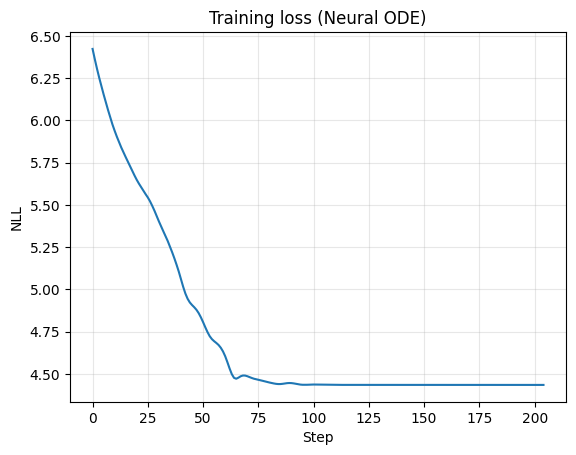

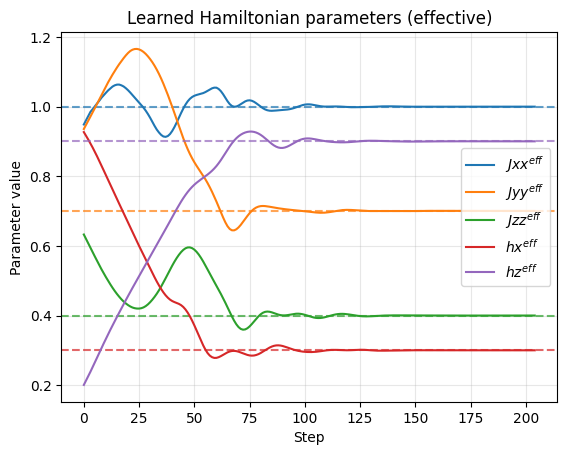

In [15]:

def train_neural_ode_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    hidden: int = 32,
    dc_scale: float = 0.05,
    m: int = 20,
    regularization: float = 0.001,
    init: list = None,  
    patience_stop: int = 50,
    min_delta: float = 1e-5,
):
    n = int(dataset["n"])
    times = torch.tensor(dataset["times"], dtype=torch.float64, device=device)  # (T,)
    pauli_obs = dataset["pauli_obs"]         # numpy (P,n)
    samples = dataset["samples"]             # numpy (S,T,P,shots)
    init_states = dataset["initial_states"]  # numpy (S,2^n) complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # initial states to torch complex
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # precompute rotation matrices
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  

    # Parameters
    dim_params = 5
    if init is None:
        init = [0.5] * dim_params
    assert len(init) == dim_params, f"`init` debe tener longitud {dim_params}"

    c = nn.Parameter(torch.tensor(init, dtype=torch.float64, device=device)) # c is the "base" parameter vector that NN_phi will modify
    net = CoeffNet(hidden=hidden, dim_params=dim_params).to(device) # Neural network that outputs the correction to the parameters

    opt = torch.optim.Adam(list(net.parameters()) + [c], lr=lr) #optimizer
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, min_lr=1e-4)#scheduler 

    # True parameters 
    true_dict = dataset["true_params"]
    param_names = ["Jxx", "Jyy", "Jzz", "hx", "hz"]
    true_vec = np.array([float(true_dict[k]) for k in param_names], dtype=np.float64)

    loss_hist = []
    c_hist = []
    dc_hist = []
    c_eff_hist = []

    # early stopping
    best_loss = float("inf")
    steps_since_improve = 0

    for step in range(num_steps):
        opt.zero_grad()

        # NN_phi acts on coefficients
        dc = dc_scale * net(c)      
        c_eff = c + dc               

        H = build_ansatz_hamiltonian_torch(n, c_eff.to(torch.complex128), device=device) # Build Hamiltonian with effective parameters

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device) # Accumulate log-probabilities
        count = 0

        for s in range(S): # Loop over initial states
            psi0 = init_states_t[s]  # psi at t=0 for this initial state 
            psi_ts = integrate_ode_rk4(psi0, times, H, m=m)  # Integrate ODE to get psi(t)

            for ti in range(T): # Loop over times
                psi_t = psi_ts[ti] # psi at time t for this initial state
                for p in range(P): # Loop over Pauli observables
                    probs = probs_in_measurement_basis(psi_t, Urots[p]) # Probabilities in measurement basis for this time and observable
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device) # Indices of sampled outcomes
                    p_samp = probs[idx] # Probabilities of the sampled outcomes
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps)) # Accumulate log-probabilities
                    count += shots

        nll = -total_logp / count # Negative log-likelihood
        reg = regularization * torch.sum(dc**2) # L2 regularization on the correction term to prevent it from becoming too large
        loss = nll + reg # Total loss is NLL plus regularization

        loss.backward() # Backpropagate to compute gradients
        opt.step() # Update parameters

        loss_val = float(loss.detach().cpu().item()) # Get scalar loss value for logging
        loss_hist.append(loss_val) # Store loss history
        c_hist.append(c.detach().cpu().numpy().copy()) # Store base parameters history
        dc_hist.append(dc.detach().cpu().numpy().copy()) # Store correction history
        c_eff_hist.append(c_eff.detach().cpu().numpy().copy()) # Store effective parameters history

        cur_eff = c_eff_hist[-1] # Current effective parameters for logging
        cur_c = c_hist[-1] # Current base parameters for logging
        cur_dc = dc_hist[-1] # Current correction for logging

        print(
            f"[NDE] Step {step+1:4d}/{num_steps} | NLL={loss_val:.6f} | "
            f"Jxx_eff={cur_eff[0]:.4f} (true {true_vec[0]:.4f}) | "
            f"Jyy_eff={cur_eff[1]:.4f} (true {true_vec[1]:.4f}) | "
            f"Jzz_eff={cur_eff[2]:.4f} (true {true_vec[2]:.4f}) | "
            f"hx_eff={cur_eff[3]:.4f} (true {true_vec[3]:.4f}) | "
            f"hz_eff={cur_eff[4]:.4f} (true {true_vec[4]:.4f})"
        )

        # Scheduler
        scheduler.step(loss.detach())

        # Early stopping
        if loss_val < best_loss - min_delta:
            best_loss = loss_val
            steps_since_improve = 0
        else:
            steps_since_improve += 1

        if steps_since_improve >= patience_stop:
            print(
                f"[EarlyStopping] Parando en step {step+1} porque la loss no mejora "
                f"(min_delta={min_delta}) en {patience_stop} iteraciones. Best={best_loss:.6f}"
            )
            break

    history = {
        "loss": np.array(loss_hist),
        "c": np.array(c_hist),
        "dc": np.array(dc_hist),
        "c_eff": np.array(c_eff_hist),
        "true": true_vec,
        "names": param_names,
    }
    return history


# Training
init_params = np.random.uniform(0.1, 1, size=5)
history_nde_modificado = train_neural_ode_model(
    dataset,
    num_steps=500,
    lr=1e-2,
    hidden=32,
    dc_scale=0.01,
    m=20,
    regularization=0.001,
    patience_stop=50,
    min_delta=1e-5,
    init = init_params
)

plot_training_nde_eff(history_nde_modificado)